# Load data

In [25]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import preModelling.data_config as config
import preModelling.utils
from modelling.feature_importance import plot_lin_feature_importance
from modelling.modelling_config import NUM_ALL, GEO_PICK, GEO_DROP, \
  CAT_ALL, \
  N_DROPOFF_CLUSTERS, N_PICKUP_CLUSTERS, RANDOM_SEED, \
  KMEANS_BATCH_SIZE, XGB_N_JOBS, XGB_LEARNING_RATE, \
  XGB_MAX_DEPTH, XGB_TREE_METHOD, BOOL_ALL, LGBM_ESTIMATORS, LGBM_MAX_DEPTH, \
  MIN_RF_SAMPLES_LEAF, \
  MAX_RF_DEPTH, MAX_RF_FEATURES, LGBM_SUBSAMPLE, LGBM_COLSAMPLE_BYTREE, \
  XGB_ESTIMATORS, \
  XGB_SUBSAMPLE, XGB_COLSAMPLE_BYTREE, DT_MAX_DEPTH, CPP_ALPHA, RF_ESTIMATORS
from modelling.modelling_utils import feature_to_category, feature_as_bool
from modelling.transformer import num_base_pipelining, geo_base_pipelining, \
  cat_base_pipelining, \
  bool_base_pipelining, get_display_models_results, compare_models_results, \
  make_linear_pipeline

In [2]:
# Load taxi and weather data
taxi_weather_raw = pd.read_csv(config.TAXI_WEATHER_DATA_SAVE)

## split train and test set

In [3]:
train_set, test_set = preModelling.utils.split_train_test(taxi_weather_raw, config.TEST_SIZE,
                                                          config.RANDOM_STATE)

# Pipelining

In [4]:
taxi_weather = train_set.copy()
taxi_weather.drop(['trip_duration', 'trip_duration_log', 'trip_duration_min'], axis=1, inplace=True)
taxi_weather_labels = train_set[['trip_duration_log']].copy()

In [5]:
taxi_weather['hav_dist_km_log'] = np.log1p(taxi_weather['hav_dist_km'])

In [6]:
taxi_weather = feature_to_category(taxi_weather, CAT_ALL)
taxi_weather = feature_as_bool(taxi_weather, BOOL_ALL)

## preprocessing_base

In [7]:
num_base_pipeline = num_base_pipelining()
geo_pick_base_pipeline = geo_base_pipelining(N_PICKUP_CLUSTERS, RANDOM_SEED, KMEANS_BATCH_SIZE)
geo_drop_base_pipeline = geo_base_pipelining(N_DROPOFF_CLUSTERS, RANDOM_SEED, KMEANS_BATCH_SIZE)
cat_base_pipeline = cat_base_pipelining()
bool_base_pipeline = bool_base_pipelining()

preprocessing_base = ColumnTransformer([
  ('num', num_base_pipeline, NUM_ALL),
  ('cat', cat_base_pipeline, CAT_ALL),
  ('geo_pick', geo_pick_base_pipeline, GEO_PICK),
  ('geo_drop', geo_drop_base_pipeline, GEO_DROP),
  ('bool', bool_base_pipeline, BOOL_ALL)
])

## Prepare training data

In [8]:
# Prepare training data
X_train = taxi_weather[NUM_ALL + CAT_ALL + GEO_PICK + GEO_DROP + BOOL_ALL]
y_train = taxi_weather_labels['trip_duration_log']

## Linear Regression

In [9]:
linreg_base_pipeline = make_linear_pipeline('linreg', preprocessing_base)

## Decision Tree Regressor

In [10]:
tree_base_pipeline = Pipeline([
  ('pre', preprocessing_base),
  ('model',
   DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=DT_MAX_DEPTH, ccp_alpha=CPP_ALPHA)),
])

## Random Forest Regressor

In [11]:
rf_base_pipeline = Pipeline([
  ('pre', preprocessing_base),
  ('model', RandomForestRegressor(n_estimators=RF_ESTIMATORS, random_state=RANDOM_SEED,
                                  min_samples_leaf=MIN_RF_SAMPLES_LEAF, max_depth=MAX_RF_DEPTH,
                                  max_features=MAX_RF_FEATURES))
])

## Ridge

In [12]:
ridge_base_pipeline = make_linear_pipeline('ridge', preprocessing_base)

## Lasso

In [13]:
lasso_base_pipeline = make_linear_pipeline('lasso', preprocessing_base)

## lightgbm

In [14]:
lgbm_base_pipeline = Pipeline([
  ('pre', preprocessing_base),
  ('model',
   LGBMRegressor(n_estimators=LGBM_ESTIMATORS, random_state=RANDOM_SEED, max_depth=LGBM_MAX_DEPTH,
                 subsample=LGBM_SUBSAMPLE, colsample_bytree=LGBM_COLSAMPLE_BYTREE))
])


## xgboost

In [15]:
xgb_base_pipeline = Pipeline([
  ('pre', preprocessing_base),
  ('model', XGBRegressor(n_estimators=XGB_ESTIMATORS, max_depth=XGB_MAX_DEPTH,
                         learning_rate=XGB_LEARNING_RATE, random_state=RANDOM_SEED,
                         tree_method=XGB_TREE_METHOD, n_jobs=XGB_N_JOBS, subsample=XGB_SUBSAMPLE,
                         colsample_bytree=XGB_COLSAMPLE_BYTREE))
])

## Display Model Score Results

In [16]:
models_all = {
  'LinearRegression': linreg_base_pipeline,
  'Ridge': ridge_base_pipeline,
  'Lasso': lasso_base_pipeline,
  'DecisionTree': tree_base_pipeline,
  'RandomForest': rf_base_pipeline,
  'LightGBM': lgbm_base_pipeline,
  'XGBoost': xgb_base_pipeline
}

models_lin = {
  'LinearRegression': linreg_base_pipeline,
  'Ridge': ridge_base_pipeline,
  'Lasso': lasso_base_pipeline
}

models_trees = {
  'DecisionTree': tree_base_pipeline,
  'RandomForest': rf_base_pipeline,
  'LightGBM': lgbm_base_pipeline,
  'XGBoost': xgb_base_pipeline
}

### All Models

In [17]:
result_all_models_all_att = get_display_models_results(models_all, X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4030
[LightGBM] [Info] Number of data points in the train set: 777943, number of used features: 45
[LightGBM] [Info] Start training from score 6.467198


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4024
[LightGBM] [Info] Number of data points in the train set: 777943, number of used features: 45
[LightGBM] [Info] Start training from score 6.467330


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4018
[LightGBM] [Info] Number of data points in the train set: 777944, number of used features: 45
[LightGBM] [Info] Start training from score 6.465593


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Model,log-RMSE (mean),log-RMSE (std)
6,XGBoost,0.360464,0.001249
5,LightGBM,0.374689,0.003050
3,DecisionTree,0.437373,0.002637
4,RandomForest,0.457962,0.009677
0,LinearRegression,0.489408,0.003945
1,Ridge,0.489412,0.003945
2,Lasso,0.521536,0.002148


In [ ]:
compare_models_results(result_all_models_all_att, seconds=True)

# Feature Importance

## Linear Models

###  Plot top features

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def plot_lin_feature_importance(pipeline, X_train, y_train,
    model_step='model', pre_step='pre'):
  """
  Fit a linear model pipeline and plot the top 20 features based on absolute coefficient values.

  Parameters:
  - pipeline: a scikit-learn Pipeline object containing a linear model
  - X_train: training feature matrix
  - y_train: target vector
  - model_step: name of the model step in the pipeline (default: 'model')
  - pre_step: name of the preprocessing step in the pipeline (default: 'pre')

  Returns:
  - feat_df: DataFrame with feature names, importance (abs. coef), and sign
  """
  pipeline.fit(X_train, y_train)

  model = pipeline.named_steps.get(model_step)
  if model is None or not hasattr(model, 'coef_') or not isinstance(model.coef_,
                                                                    np.ndarray):
    raise AttributeError(
        f"Model step '{model_step}' does not provide valid 'coef_' attribute.")
  coefs = model.coef_
  if coefs.ndim > 1:
    coefs = coefs[0]

  feature_names = pipeline.named_steps[pre_step].get_feature_names_out()

  feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefs),
    'sign': np.sign(coefs)
  }).sort_values(by='importance', ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(x='importance', y='feature', data=feat_df.head(20))
  plt.title("Top 20 feature coefficients (absolute)")
  plt.tight_layout()
  plt.show()
  return feat_df


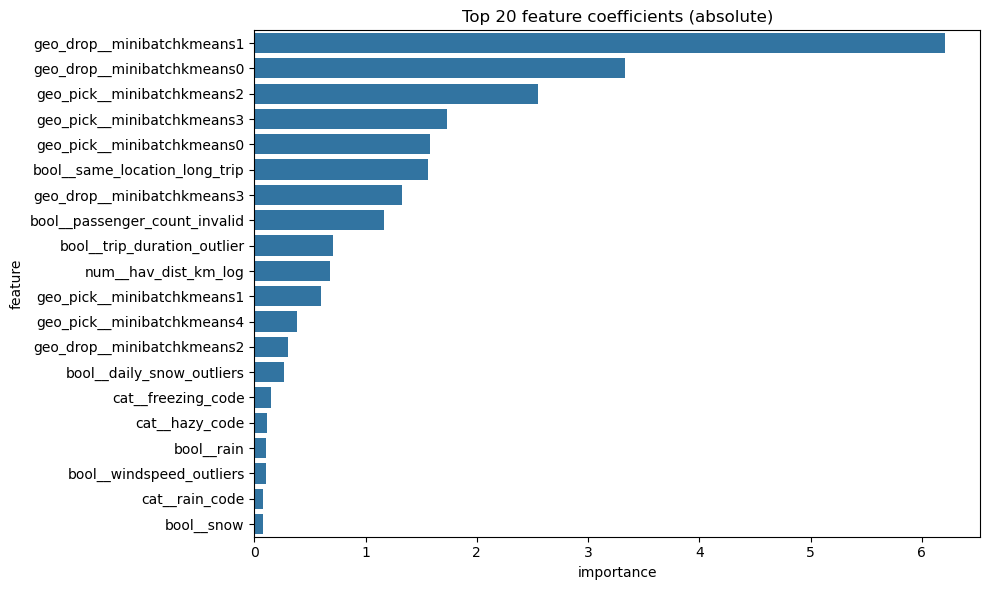

,feature,importance,sign
32,geo_drop__minibatchkmeans1,6.212284,-1.0
31,geo_drop__minibatchkmeans0,3.334143,1.0
28,geo_pick__minibatchkmeans2,2.545817,-1.0
29,geo_pick__minibatchkmeans3,1.730073,1.0
26,geo_pick__minibatchkmeans0,1.582419,1.0
43,bool__same_location_long_trip,1.562395,1.0
34,geo_drop__minibatchkmeans3,1.323567,1.0
42,bool__passenger_count_invalid,1.167523,-1.0
44,bool__trip_duration_outlier,0.704324,-1.0
1,num__hav_dist_km_log,0.679726,1.0


In [28]:
plot_lin_feature_importance(linreg_base_pipeline, X_train, y_train)

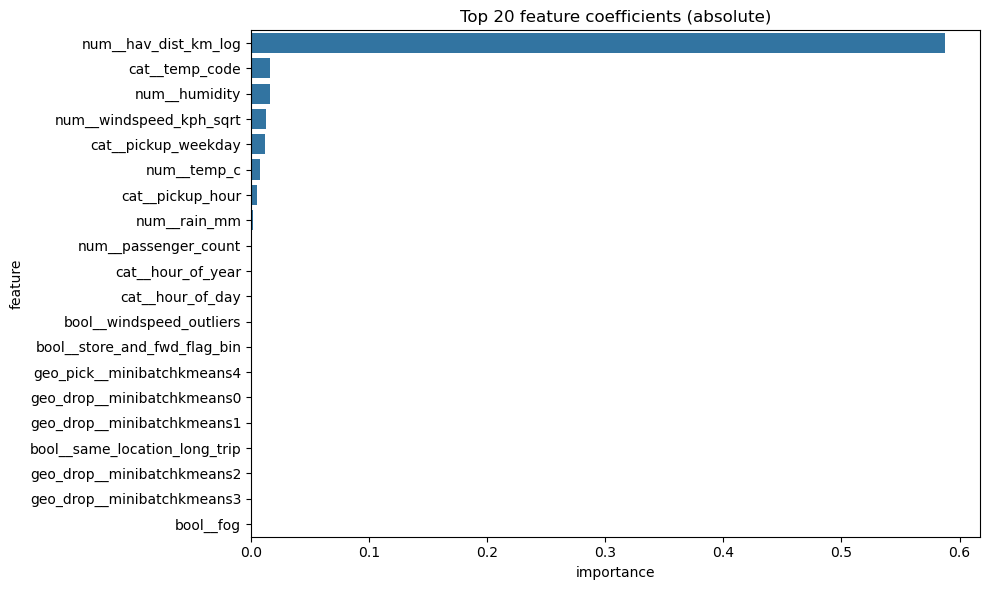

,feature,importance,sign
1,num__hav_dist_km_log,5.879418e-01,1.0
16,cat__temp_code,1.600600e-02,1.0
4,num__humidity,1.574294e-02,-1.0
3,num__windspeed_kph_sqrt,1.293801e-02,1.0
10,cat__pickup_weekday,1.225227e-02,-1.0
2,num__temp_c,7.317398e-03,1.0
13,cat__pickup_hour,5.367783e-03,1.0
6,num__rain_mm,2.009105e-03,1.0
0,num__passenger_count,3.178061e-04,1.0
14,cat__hour_of_year,6.970743e-06,1.0


In [29]:
plot_lin_feature_importance(lasso_base_pipeline, X_train, y_train)

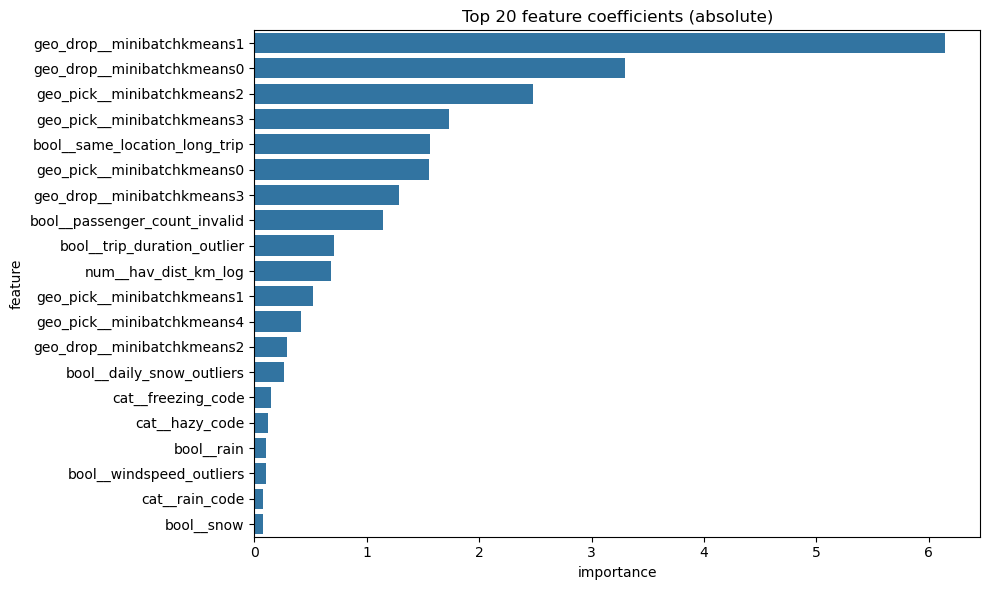

,feature,importance,sign
32,geo_drop__minibatchkmeans1,6.147045,-1.0
31,geo_drop__minibatchkmeans0,3.297249,1.0
28,geo_pick__minibatchkmeans2,2.475275,-1.0
29,geo_pick__minibatchkmeans3,1.729289,1.0
43,bool__same_location_long_trip,1.561483,1.0
26,geo_pick__minibatchkmeans0,1.557253,1.0
34,geo_drop__minibatchkmeans3,1.285887,1.0
42,bool__passenger_count_invalid,1.145176,-1.0
44,bool__trip_duration_outlier,0.704472,-1.0
1,num__hav_dist_km_log,0.679603,1.0


In [30]:
plot_lin_feature_importance(ridge_base_pipeline, X_train, y_train)

In [38]:

def plot_tree_feature_importance(pipeline, X_train, y_train,
    model_step='model', pre_step='pre'):
  """
  Fit a tree-based model pipeline and plot the top N features based on feature importance.

  Parameters:
  - pipeline: a scikit-learn Pipeline object with a tree-based model as final step
  - model_step: name of the model step in the pipeline (default: 'model')
  - pre_step: name of the preprocessing step in the pipeline (default: 'pre')
  - top_n: number of top features to display (default: 20)

  Returns:
  - feat_df: DataFrame with feature names and importance scores
  """

  pipeline.fit(X_train, y_train)

  model = pipeline.named_steps.get(model_step)
  if model is None or not hasattr(model, 'feature_importances_'):
    raise AttributeError(
        f"Model step '{model_step}' does not provide valid 'feature_importances_'.")

  feature_names = pipeline.named_steps[pre_step].get_feature_names_out()
  importances = model.feature_importances_

  feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
  }).sort_values(by='importance', ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(x='importance', y='feature', data=feat_df.head(20))
  plt.title(f"Top {20} feature importances")
  plt.tight_layout()
  plt.show()
  return feat_df


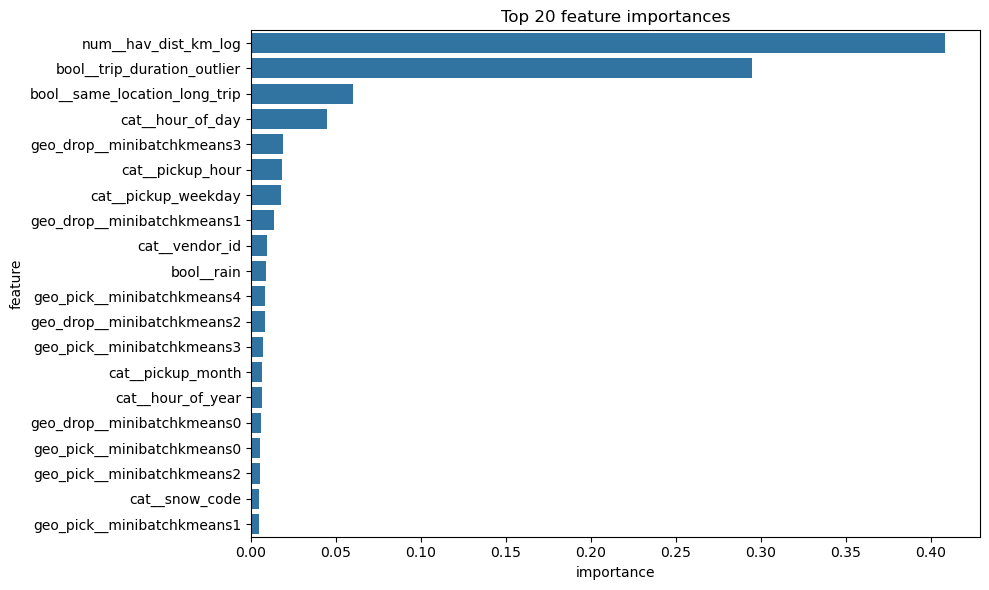

,feature,importance
1,num__hav_dist_km_log,0.408380
44,bool__trip_duration_outlier,0.294458
43,bool__same_location_long_trip,0.059855
15,cat__hour_of_day,0.044514
34,geo_drop__minibatchkmeans3,0.018831
13,cat__pickup_hour,0.018244
10,cat__pickup_weekday,0.017465
32,geo_drop__minibatchkmeans1,0.013698
12,cat__vendor_id,0.009168
37,bool__rain,0.008652


In [39]:
plot_tree_feature_importance(xgb_base_pipeline, X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4019
[LightGBM] [Info] Number of data points in the train set: 1166915, number of used features: 45
[LightGBM] [Info] Start training from score 6.466707


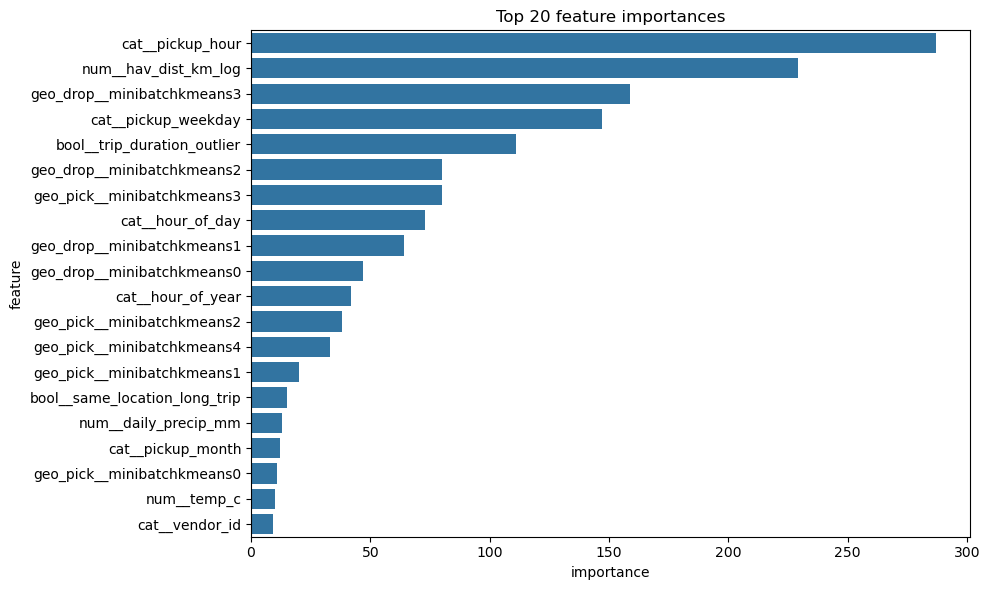

,feature,importance
13,cat__pickup_hour,287
1,num__hav_dist_km_log,229
34,geo_drop__minibatchkmeans3,159
10,cat__pickup_weekday,147
44,bool__trip_duration_outlier,111
33,geo_drop__minibatchkmeans2,80
29,geo_pick__minibatchkmeans3,80
15,cat__hour_of_day,73
32,geo_drop__minibatchkmeans1,64
31,geo_drop__minibatchkmeans0,47


In [40]:
plot_tree_feature_importance(lgbm_base_pipeline, X_train, y_train)

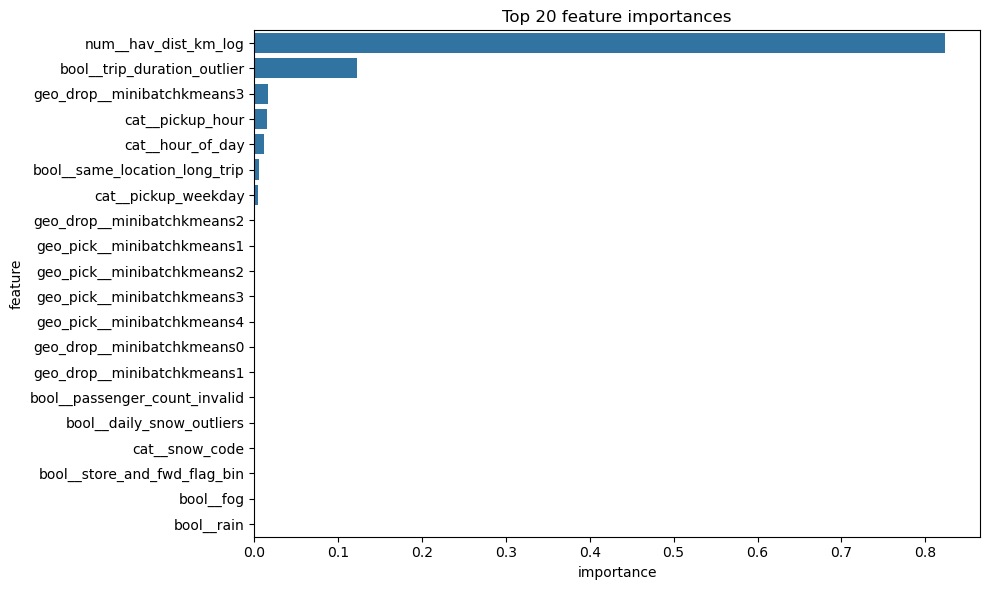

,feature,importance
1,num__hav_dist_km_log,0.824147
44,bool__trip_duration_outlier,0.122948
34,geo_drop__minibatchkmeans3,0.016485
13,cat__pickup_hour,0.014458
15,cat__hour_of_day,0.011692
43,bool__same_location_long_trip,0.005746
10,cat__pickup_weekday,0.004524
33,geo_drop__minibatchkmeans2,0.000000
27,geo_pick__minibatchkmeans1,0.000000
28,geo_pick__minibatchkmeans2,0.000000


In [41]:
plot_tree_feature_importance(tree_base_pipeline, X_train, y_train)

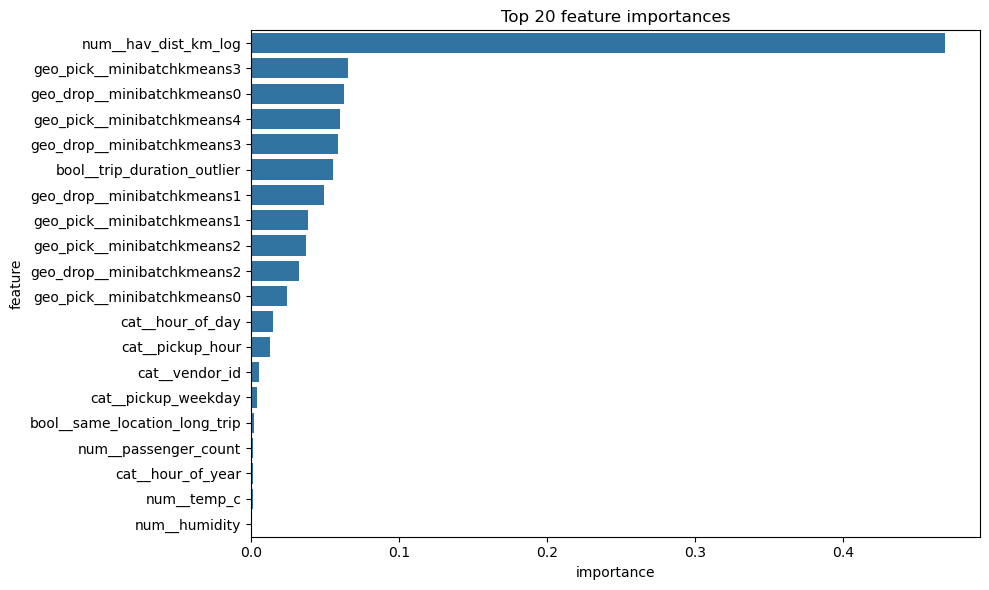

,feature,importance
1,num__hav_dist_km_log,4.692562e-01
29,geo_pick__minibatchkmeans3,6.547748e-02
31,geo_drop__minibatchkmeans0,6.265310e-02
30,geo_pick__minibatchkmeans4,5.999779e-02
34,geo_drop__minibatchkmeans3,5.858018e-02
44,bool__trip_duration_outlier,5.567762e-02
32,geo_drop__minibatchkmeans1,4.945271e-02
27,geo_pick__minibatchkmeans1,3.826421e-02
28,geo_pick__minibatchkmeans2,3.720419e-02
33,geo_drop__minibatchkmeans2,3.246218e-02


In [42]:
plot_tree_feature_importance(rf_base_pipeline, X_train, y_train)